<a href="https://colab.research.google.com/github/fishball0112/roy/blob/main/(Final)Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [2]:

!wget https://raw.githubusercontent.com/fishball0112/roy/refs/heads/main/1K_PDU_total.csv

--2024-12-10 09:09:44--  https://raw.githubusercontent.com/fishball0112/roy/refs/heads/main/1K_PDU_total.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15025 (15K) [text/plain]
Saving to: ‘1K_PDU_total.csv’

1K_PDU_total.csv    100%[===================>]  14.67K  --.-KB/s    in 0s      

2024-12-10 09:09:44 (34.7 MB/s) - ‘1K_PDU_total.csv’ saved [15025/15025]



In [ ]:
#!wget https://raw.githubusercontent.com/fishball0112/roy/refs/heads/main/heat_load.csv

--2024-11-12 06:26:12--  https://raw.githubusercontent.com/fishball0112/roy/refs/heads/main/heat_load.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52690 (51K) [text/plain]
Saving to: ‘heat_load.csv’

heat_load.csv       100%[===================>]  51.46K  --.-KB/s    in 0.001s  

2024-11-12 06:26:12 (61.9 MB/s) - ‘heat_load.csv’ saved [52690/52690]



## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import warnings
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense
from tensorflow.python.keras.layers import RepeatVector, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff


from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

## Data Plot

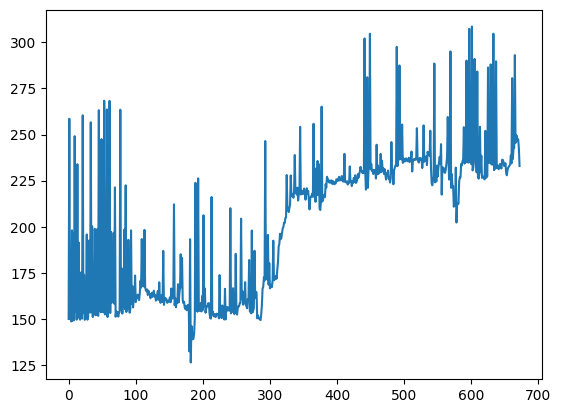

In [4]:
training_set = pd.read_csv('1K_PDU_total.csv')
#training_set = pd.read_csv('heat_load.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'heat_load.csv')
plt.plot(training_set, label = '1K_PDU_total.csv')
plt.show()

## Dataloading

In [31]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [32]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

In [39]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Alton (Below 2 rows)
train_loss_record = []
test_loss_record = []

# Train the model
for epoch in range(num_epochs):
    lstm.train() # Alton
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_loss_record.append(loss.detach().numpy().tolist()) # Alton

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    # Alton
    lstm.eval()
    outputs_test = lstm(testX)
    test_loss = criterion(outputs_test, testY)
    test_loss_record.append(test_loss.detach().numpy().tolist())



Epoch: 0, loss: 0.17001
Epoch: 100, loss: 0.01114
Epoch: 200, loss: 0.01074
Epoch: 300, loss: 0.01038
Epoch: 400, loss: 0.01001
Epoch: 500, loss: 0.00970
Epoch: 600, loss: 0.00949
Epoch: 700, loss: 0.00916
Epoch: 800, loss: 0.00906
Epoch: 900, loss: 0.00903
Epoch: 1000, loss: 0.00900
Epoch: 1100, loss: 0.00898
Epoch: 1200, loss: 0.00895
Epoch: 1300, loss: 0.00892
Epoch: 1400, loss: 0.00888
Epoch: 1500, loss: 0.00884
Epoch: 1600, loss: 0.00880
Epoch: 1700, loss: 0.00876
Epoch: 1800, loss: 0.00873
Epoch: 1900, loss: 0.00869


#  Testing for heatload Dataset

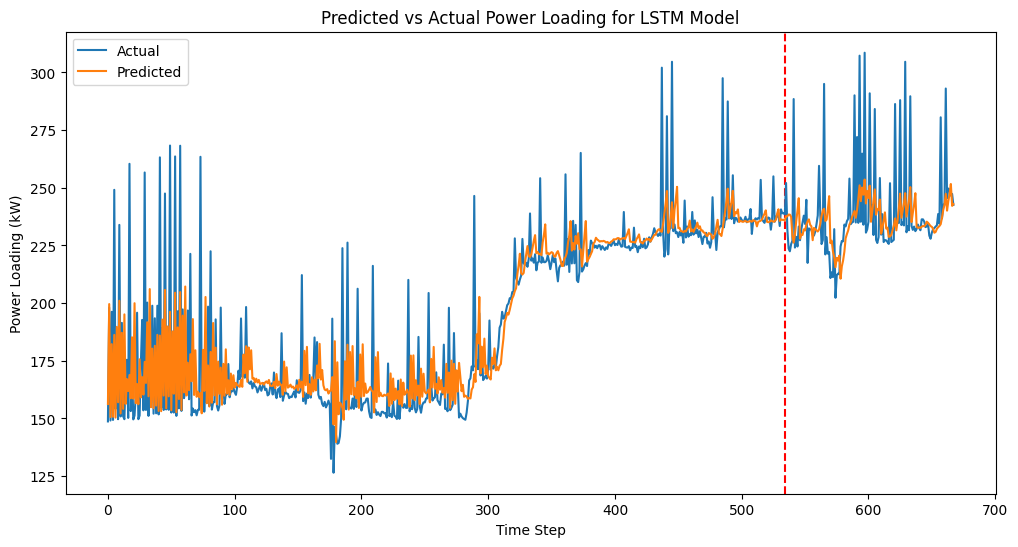

In [55]:
plt.figure(figsize=(12, 6))
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="Actual")
plt.plot(data_predict, label="Predicted")
plt.xlabel('Time Step')
plt.ylabel('Power Loading (kW)')
plt.legend()
plt.title('Predicted vs Actual Power Loading for LSTM Model')
plt.show()

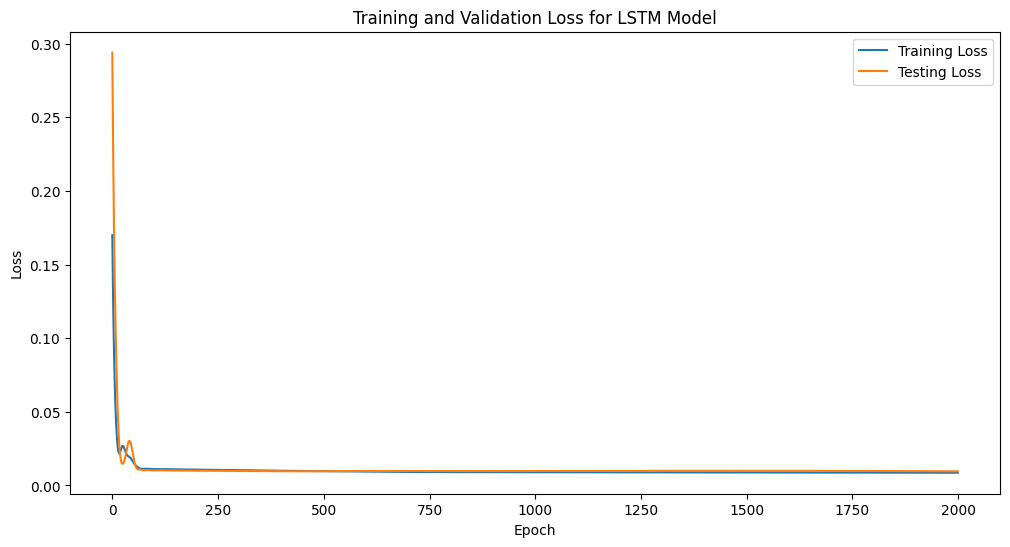

In [56]:
plt.figure(figsize=(12, 6))
plt.title('Training and Validation Loss for LSTM Model')
plt.plot(train_loss_record, label='Training Loss')
plt.plot(test_loss_record, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
mse=mean_squared_error(dataY_plot,data_predict)
print(mse)

293.47192


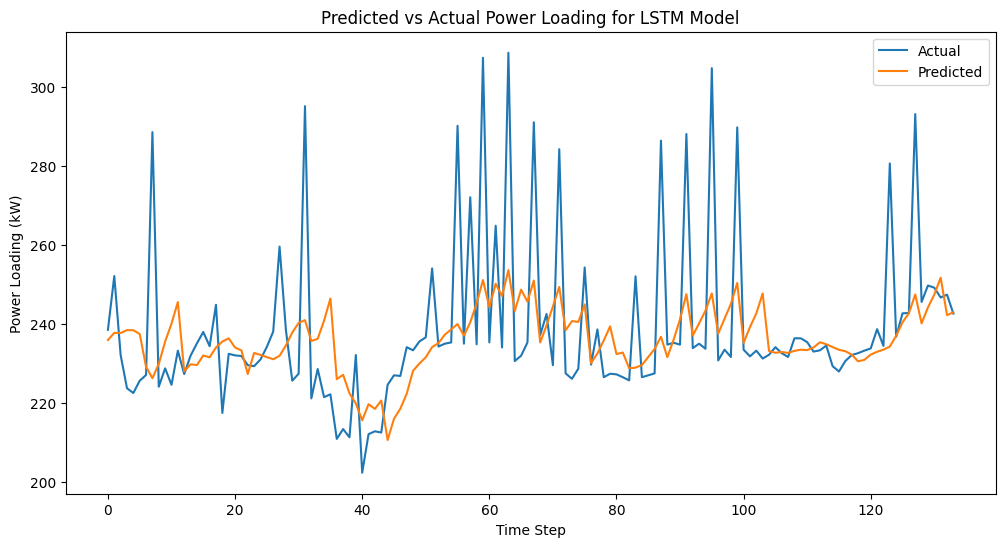

In [57]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(12, 6))
plt.plot(dataY_plot[train_size:], label="Actual")  # Testing actual values
plt.plot(data_predict[train_size:], label="Predicted")  # Testing predictions

plt.xlabel('Time Step')
plt.ylabel('Power Loading (kW)')
plt.legend()
plt.title('Predicted vs Actual Power Loading for LSTM Model')
plt.show()